# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [ ]:
from __future__ import print_function
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [ ]:
def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    
    # YOUR CODE GOES HERE
    w = np.zeros(d)
    sigma = np.zeros((d, d))
    #Take non-infinite alphas for relevant features
    idx = (alpha != np.inf)
    sigma[np.ix_(idx, idx)] = np.linalg.inv(beta * np.dot(X[:, idx].T, X[:, idx]) + np.diag(alpha[idx]))
    w[idx] = np.dot(beta * sigma[idx][:, idx], np.dot(X[:, idx].T, t))
    return w, sigma


def update_alpha_beta(X, t, alpha, beta):
    """Update the hyperperemeters to increase evidence"""

    # YOUR CODE GOES HERE
    w, sigma = get_w_sigma(X, t, alpha, beta)
    #Take positions where alphas are non-infinite (less or equal to 1e8, since larger values are seems to be equated to inf according to further code) and w's are non-zero
    idx = (alpha <= 1e8) & (w != 0)
    alpha_new = np.full(d, np.inf)
    alpha_new[idx] = (1 - alpha[idx] * np.diag(sigma[idx][:, idx])) / (w[idx] * w[idx])
    n = X.shape[0]
    beta_new = (n - np.sum(1 - alpha[idx] * np.diag(sigma[idx][:, idx]))) / np.linalg.norm(t - np.dot(X[:, idx], w[idx])) ** 2
    return alpha_new, beta_new


def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""

    # YOUR CODE GOES HERE
    #Initialize alphas and beta with value 1 (like on the lecture)
    d = X.shape[1]
    alpha = np.ones(d)
    beta = 1
    for i in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta)
    w, sigma = get_w_sigma(X, t, alpha, beta)
    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

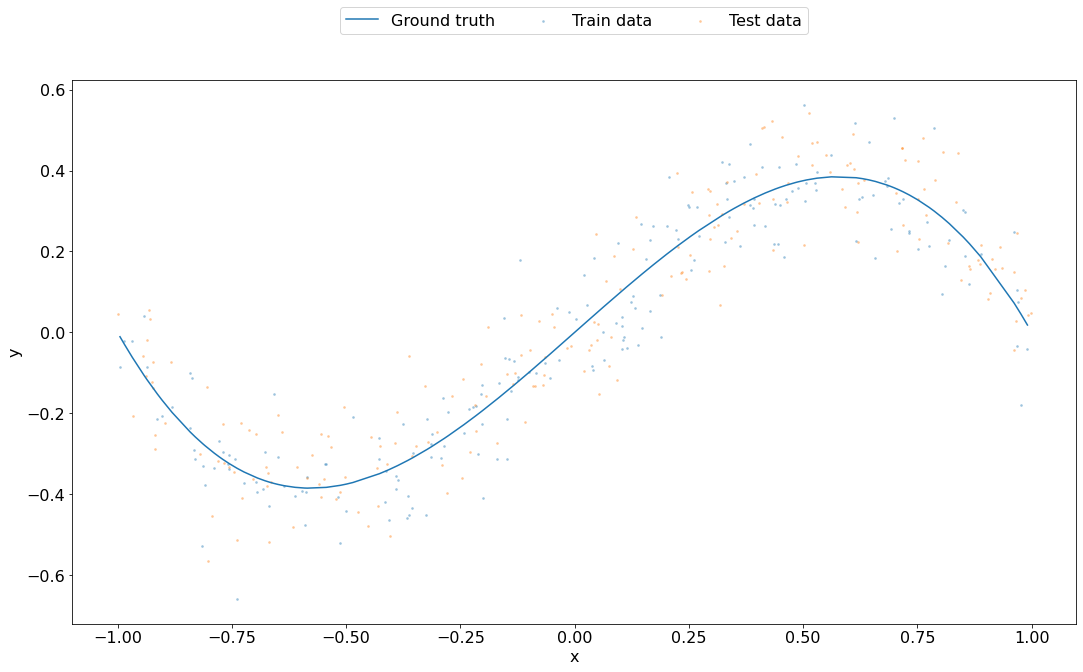

In [ ]:
# Data generation

plt.rcParams['font.size'] = 16


def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

Для дальнейших сравнений будем замерять также и время работы алгоритмов.

In [ ]:
# Relevance Vector Regression
%%timeit
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

2.77 s ± 750 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from sklearn.linear_model import RidgeCV

In [ ]:
# Ridge Regression with Cross-Validation
%%timeit
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

2.86 s ± 40.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from sklearn.linear_model import LassoCV, Lasso

In [ ]:
# Lasso Regression with Cross-Validation
%%timeit
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069097918335701, tolerance: 0.0012854460800422094
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069097918335701, tolerance: 0.0012854460800422094
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069097918335701, tolerance: 0.0012854460800422094
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality ga

6.38 s ± 88.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069097918335701, tolerance: 0.0012854460800422094
  positive,


In [ ]:
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:644: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0069097918335701, tolerance: 0.0012854460800422094
  positive,


Relevance Vector Regression
Features remaining: 3 / 21
Train error: 0.009052796709304888
Test error:  0.009793464126595344
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.009095034553223615
Test error:  0.00996144205308367
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.008878963547469499
Test error:  0.010139505424318362


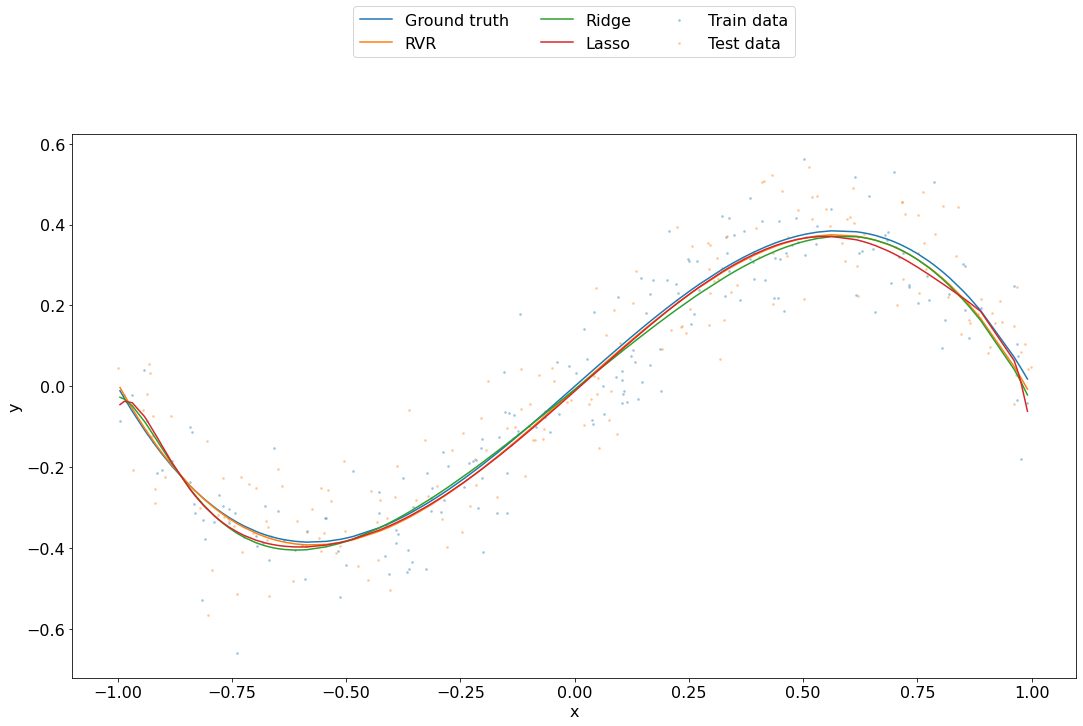

In [ ]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

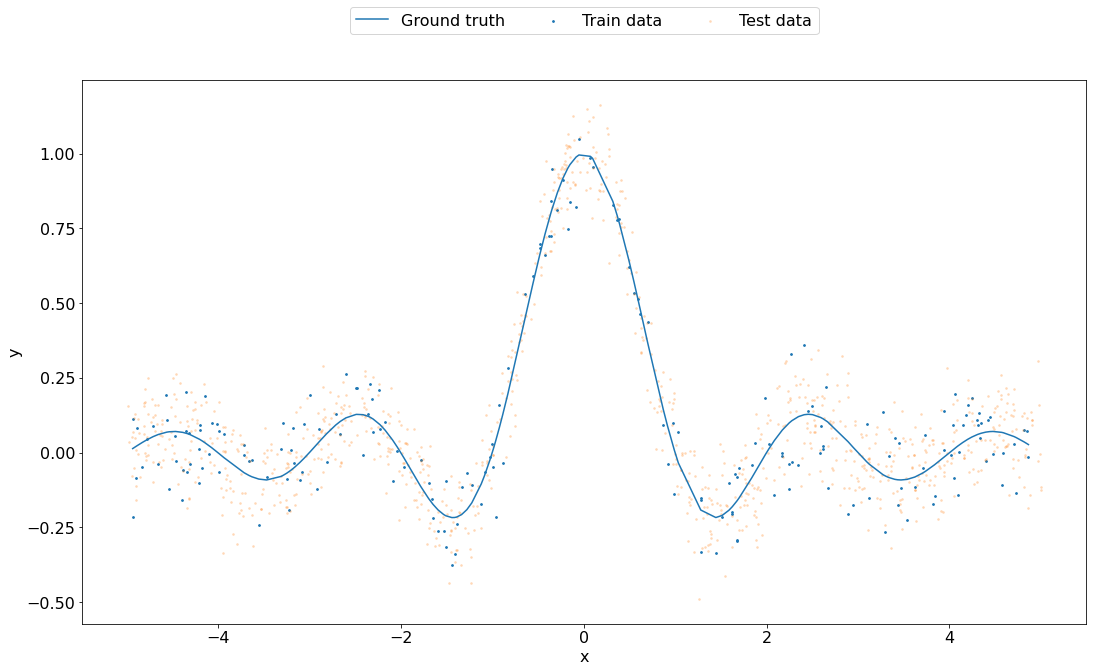

In [ ]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape((points_train.shape[0], 1)))
#For equalty of numbers of features in train and test 
X_test = rbf_kernel(points_test.reshape((points_test.shape[0], 1)), points_train.reshape((points_train.shape[0], 1)))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

Аналогично сравним и по времени работы.

In [ ]:
# Relevance Vector Regression
%%timeit
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

4.27 s ± 70.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# Lasso Regression with Cross-Validation
%%timeit
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

1min 59s ± 4.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
from sklearn.svm import SVR

In [ ]:
# Support Vector Regression
%%timeit
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

2.65 ms ± 74.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 9 / 200
Train error: 0.010508846200525487
Test error:  0.05451804825082526
--------------------------------------------------
Lasso Regression
Objects remaining: 154 / 200
Train error: 0.010129624357538232
Test error:  0.054447550361159607
--------------------------------------------------
Support Vector Regression
Objects remaining: 76 / 200
Train error: 0.01034537184785676
Test error:  0.05683389724182382


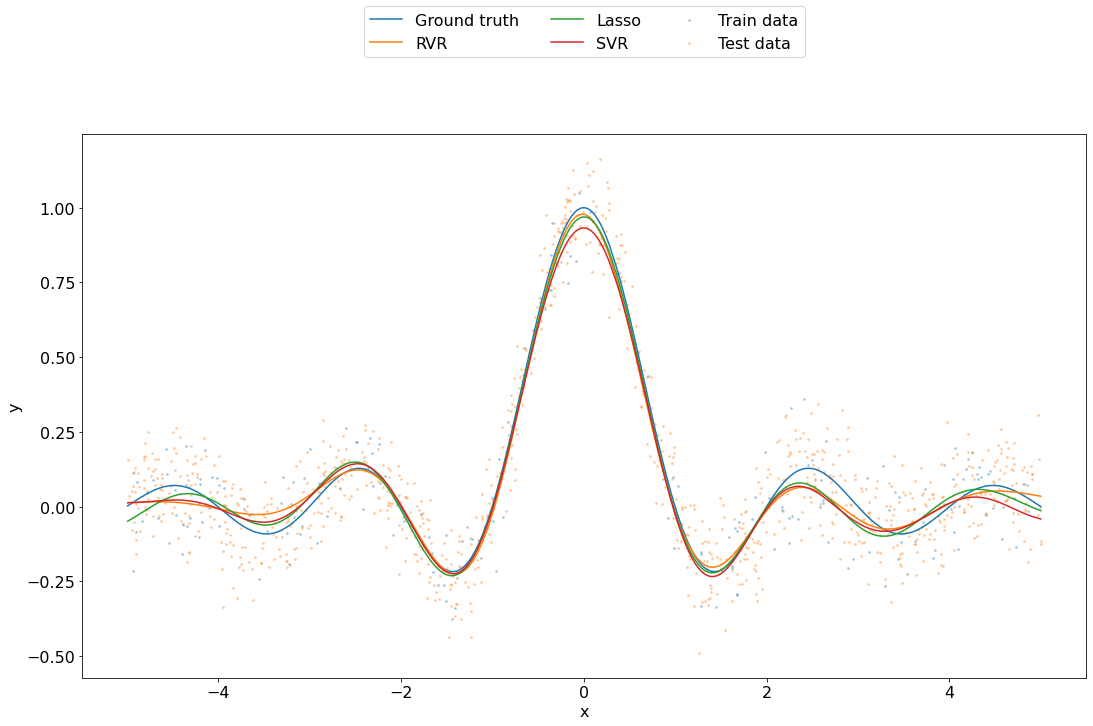

In [ ]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

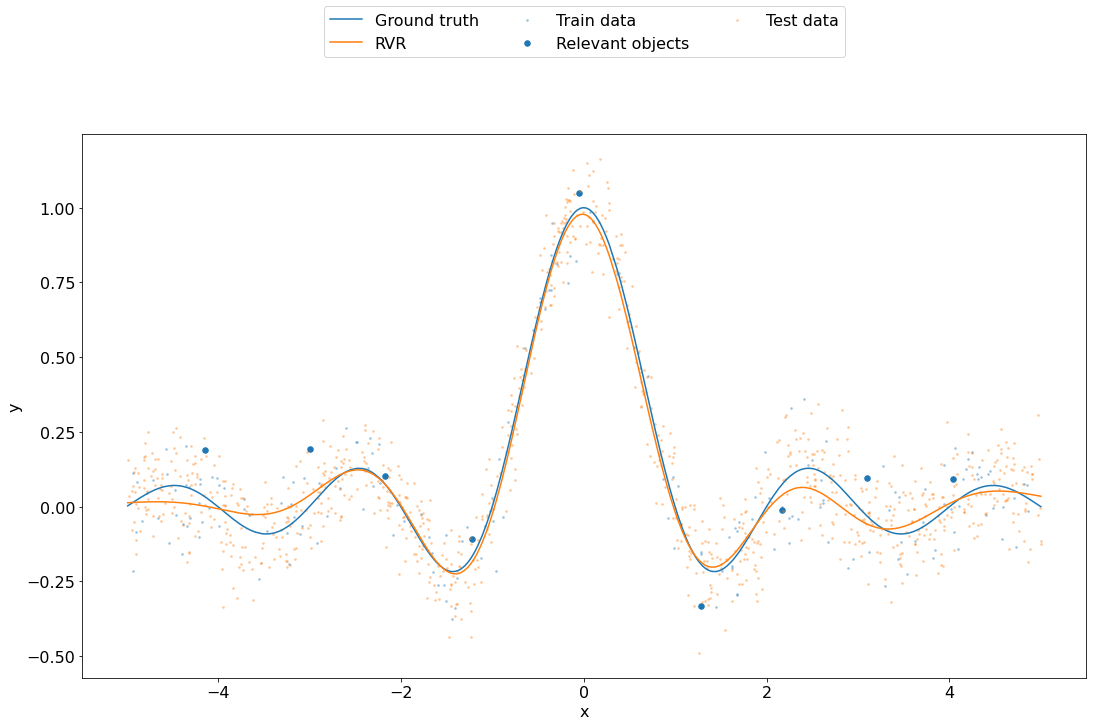

In [ ]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
В этом поле опишите свои наблюдения и сформулируйте свои выводы

**Выводы и наблюдения**

В целом можно сказать, что в обеих рассмотренных задачах метод релевантных векторов показывает весьма неплохие результаты в сравнении с остальными алгоритмами, имеет высокое качество предсказания. В задаче восстановления полинома он имеет наименьшую ошибку на тестовой выборке, в задаче с RBF-признаками незначительно уступает лишь линейной регрессии с L1-регуляризацией. Однако в целом результаты работы сравниваемых алгоритмов достаточно близки.

Заметной особенностью метода релевантных векторов является то, что он оставляет довольно небольшое число признаков (по сути объектов исходной выборки в случае использования RBF-признаков), значительно меньше остальных алгоритмов. Это свидетельствует о том, что метод релевантных векторов можно использовать для значительного снижения размерности решаемой задачи, причем без потерь качества прогноза. Решение получается разреженным, в итоге проводится довольно агрессивный отбор признаков/объектов, а также признаки регуляризуются независимо. Выделяются лишь наиболее важные признаки для дальнейшей настройки на них, им соответствуют конечные значения коэффициентов $\alpha$, чем ближе к $0$, тем выше значимость конкретного признака.

Что касается времени работы алгоритмов, то во всех экспериментах метод релевантных векторов работает быстрее всего, однако во всех случаях он оставлял очень небольшое число признаков/объектов. Из определения и устройства данного алгоритма вытекает, что если значимых объектов/признаков много, и, например, у RVR и линейной регресии с L1 или L2 регуляризацией будет отбираться почти одинаковое число признаков/объектов, то метод релевантных векторов будет работать во много раз медленнее (в силу многократного обращения матрицы при поиске $w_{MP}$). 

Если рассматривать релевантные векторы (объекты), найденные методом в задаче с RBF-признаками, которые по сути были получены за счет отбора признаков, то можно сказать, что RVR находит наиболее важные и значимые из них, наиболее соответствующие данным и их характерным особенностям. Это хорошо заметно на графике с релевантными векторами (объектами), их немного, но они по сути отвечают за характерные точки аппроксимации истинной зависимости (пики, перегибы и т. д., по сути определяющие кривую), хорошо отражают структуру и расположение данных. SVM в отличие от RVR, как известно, находит опорные объекты, по которым определяется вектор весов. Исходя из определения алгоритма и визуальных наблюдений, можно сказать, что опорные объекты "ограничивают" данные, в некотором смысле задают "$\varepsilon$-трубку" вокруг приближаемой зависимости, они в большей степени влияют на вектор весов и аппроксимацию целевой зависимости. В целом они также описывают данные и их устройство, но их значительно больше, чем релевантных векторов. Для наглядности можно изобразить найденные в задаче опорные объекты:


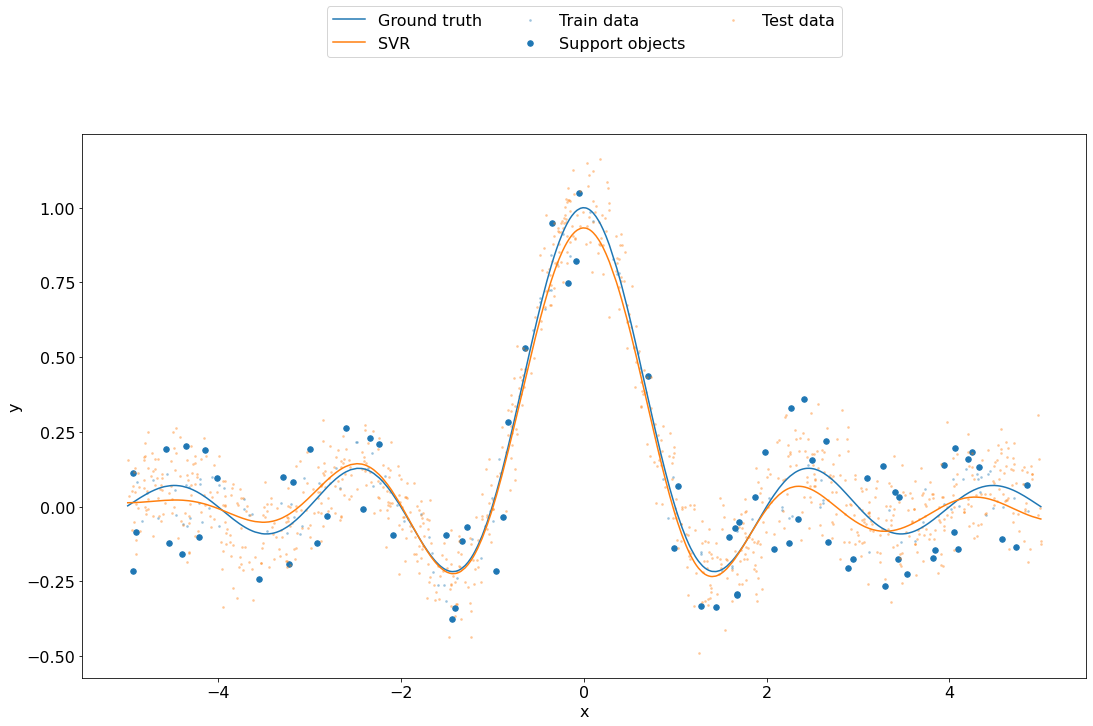

In [ ]:
support = svr.support_
fig, ax = plt.subplots(figsize=(18, 10))
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[support], t_train[support], c='tab:blue', s=30, label='Support objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()


Действительно, опорных объектов значительно больше, чем релевантных, и они в большей степени "обрамляют" выборку, задают ее форму, чем задают ключевые особенности и характеристики объектов (экстремумы, перегибы и т. д.).

Таким образом, можно сказать, что метод релевантных векторов для регресии хорошо проявляет себя в сравнении с другими методами, позволяет провести достаточно сильный отбор наиболее важных признаков/объектов, позволяет значительно снизить размерность задачи, позволяет выделить наиболее важные и характерные (релевантные) признаки/объекты, по сути хорошо описывающие структуру и особенности данных и целевой зависимости. Он имеет высокое качество прогноза, и можно сказать, что он имеет хорошую обобщающую способность. Также в совокупности с использованием ядер (kernel trick) данный алгоритм может быть использован для отбора наиболее важных и значимых объектов среди некоторого набора данных. 